In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from xgboost import XGBRegressor
from minisom import MiniSom 
from sklearn.model_selection import KFold, train_test_split


In [ ]:
mpl.rcParams["text.usetex"] = True
mpl.rcParams["font.family"] = "serif"

In [5]:
df = pd.read_csv('modifiedDR18.csv')

In [6]:
df.head()

,specObjID,objid,ra,dec,specz,specz_err,specType,photpType,extinction_u,extinction_g,extinction_r,extinction_i,extinction_z,psfMag_u_corr,psfMag_g_corr,psfMag_r_corr,psfMag_i_corr,psfMag_z_corr,psfMagErr_u,psfMagErr_g,psfMagErr_r,psfMagErr_i,psfMagErr_z
0,1962535672963164160,1237664106851205271,147.20540,12.684510,0.130437,0.000032,3,3,0.155211,0.120940,0.083665,0.062172,0.046245,21.85535,19.82888,18.92921,18.36425,18.10023,0.132154,0.023431,0.030034,0.015538,0.025271
1,1962535123207350272,1237664106851336294,147.46108,12.695224,0.029846,0.000009,3,3,0.136708,0.106522,0.073691,0.054761,0.040732,19.25492,17.58513,16.60391,16.47843,15.96241,0.026569,0.013166,0.015746,0.018543,0.012945
2,1962532649306187776,1237664106851336535,147.42427,12.657470,0.029511,0.000009,3,3,0.132777,0.103459,0.071572,0.053186,0.039560,20.10272,18.90216,18.27798,18.32100,17.94718,0.039893,0.015308,0.016897,0.020418,0.021066
3,1962536497596884992,1237664106851336600,147.53003,12.746130,0.029619,0.000011,3,3,0.143691,0.111963,0.077455,0.057558,0.042812,19.77782,18.68069,18.01435,18.00995,17.60496,0.032670,0.014416,0.016443,0.019420,0.017839
4,1962548042468976640,1237664106851401906,147.61414,12.765495,0.004764,0.000005,3,3,0.142095,0.110720,0.076595,0.056919,0.042337,18.64369,17.99965,17.58385,17.82648,17.32453,0.062898,0.063200,0.026554,0.059448,0.019980


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1325129 entries, 0 to 1325128
Data columns (total 23 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   specObjID      1325129 non-null  uint64 
 1   objid          1325129 non-null  int64  
 2   ra             1325129 non-null  float64
 3   dec            1325129 non-null  float64
 4   specz          1325129 non-null  float64
 5   specz_err      1325129 non-null  float64
 6   specType       1325129 non-null  int64  
 7   photpType      1325129 non-null  int64  
 8   extinction_u   1325129 non-null  float64
 9   extinction_g   1325129 non-null  float64
 10  extinction_r   1325129 non-null  float64
 11  extinction_i   1325129 non-null  float64
 12  extinction_z   1325129 non-null  float64
 13  psfMag_u_corr  1325129 non-null  float64
 14  psfMag_g_corr  1325129 non-null  float64
 15  psfMag_r_corr  1325129 non-null  float64
 16  psfMag_i_corr  1325129 non-null  float64
 17  psfMag_z

In [8]:
df.columns

Index(['specObjID', 'objid', 'ra', 'dec', 'specz', 'specz_err', 'specType',
       'photpType', 'extinction_u', 'extinction_g', 'extinction_r',
       'extinction_i', 'extinction_z', 'psfMag_u_corr', 'psfMag_g_corr',
       'psfMag_r_corr', 'psfMag_i_corr', 'psfMag_z_corr', 'psfMagErr_u',
       'psfMagErr_g', 'psfMagErr_r', 'psfMagErr_i', 'psfMagErr_z'],
      dtype='object')

In [9]:
df.dropna(inplace=True)

In [11]:
X = df[['psfMag_u_corr', 'psfMag_g_corr', 'psfMag_r_corr', 'psfMag_i_corr', 'psfMag_z_corr']].values
y = df['specz'].values

In [12]:
#training, validation and test samples of size 4%, 18% and 78% of the whole data set. This corresponds to approximately 53k, 238k and 1033k respectively.

# Split into training (4%) and remaining (validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=0.04, random_state=42)

# Split the remaining data into validation (18%) and test (78%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, train_size=0.18/0.96, random_state=42)

#### Evaluation Metrics Function

In [13]:
def calculate_metrics(y_true, y_pred):
    delta_z = (y_pred - y_true) / (1 + y_true)
    
    median_delta_z = np.median(np.abs(delta_z))
    sigma_68 = np.percentile(np.abs(delta_z), 68)
    outlier_fraction = np.mean(np.abs(delta_z) > 0.15)

    return {
        "median_delta_z": median_delta_z,
        "sigma_68": sigma_68,
        "outlier_fraction": outlier_fraction
    }

## Base Learners

#### SOM

In [ ]:
class SOManager:
    
    def __init__(self, n_neurons=768):
        self.n_neurons = n_neurons
        self.som = None
        self.cell_z = {}
        self.cell_means = {}
        self.global_mean = None  
        
    def train(self, X, y, iterations=100):
        grid_size = int(np.sqrt(self.n_neurons))  
        self.som = MiniSom(grid_size, grid_size, X.shape[1], sigma=1.5, learning_rate=0.5)
        self.som.random_weights_init(X)
        self.som.train_random(X, iterations)
        
        self.cell_z = {}
        for i, x in enumerate(X):
            winner = self.som.winner(x)  
            if winner not in self.cell_z:
                self.cell_z[winner] = []
            self.cell_z[winner].append(y[i])
        
        self.cell_means = {k: np.mean(v) for k, v in self.cell_z.items()}
        self.global_mean = np.mean(y)  
    
    def predict(self, X):
        predictions = []
        for x in X:
            winner = self.som.winner(x)
            if winner in self.cell_means:
                predictions.append(self.cell_means[winner])
            else:
                predictions.append(self.global_mean)  
        
        return np.array(predictions)


####  DT

In [15]:
class DTManager:
    
    def __init__(self, min_samples_leaf=20):
        self.model = DecisionTreeRegressor(min_samples_leaf=min_samples_leaf)
        
    def train(self, X, y):
        self.model.fit(X, y)
    
    def predict(self, X):
        return self.model.predict(X)

####  AdaBoost

In [16]:
class AdaBoostManager:
    
    def __init__(self, n_estimators=50, min_samples_leaf=20):
        self.model = AdaBoostRegressor(
            DecisionTreeRegressor(min_samples_leaf=min_samples_leaf),
            n_estimators=n_estimators)

    def train(self, X, y):
        self.model.fit(X, y)

    def predict(self, X):
        return self.model.predict(X)

#### XGBoost

In [ ]:
class XGBoostManager:
    
    def __init__(self, n_estimators=100,min_samples_leaf=20):
        self.model = XGBRegressor(
            n_estimators=n_estimators,
            learning_rate=0.1,
            max_depth=3,
            min_child_weight=min_samples_leaf,  
            subsample=0.8,               
            colsample_bytree=0.8,  
            tree_method="hist",                 
            random_state=42
        )

    def train(self, X, y):
        self.model.fit(X, y)

    def predict(self, X):
        return self.model.predict(X)


### Stacking class

In [ ]:
class StackingManager:
    def __init__(self, L=2, N=25, model_types=['dt', 'som'], min_samples_leaf=20, n_estimators=50, n_neurons=768, meta_model=None):
        self.L = L  
        self.N = N  
        self.model_types = model_types  
        self.min_samples_leaf = min_samples_leaf
        self.n_estimators = n_estimators
        self.n_neurons = n_neurons
        self.meta_model = meta_model if meta_model else LinearRegression()  
        self.learners = [] 
        self.layer_outputs = [] 

    def _create_model(self, model_type):
        if model_type == 'dt':
            return DTManager(min_samples_leaf=self.min_samples_leaf)
        elif model_type == 'som':
            return SOManager(n_neurons=self.n_neurons)
        elif model_type == 'adaboost':
            return AdaBoostManager(n_estimators=self.n_estimators, min_samples_leaf=self.min_samples_leaf)
        elif model_type == 'xgboost':
            return XGBoostManager(n_estimators=self.n_estimators, min_samples_leaf=self.min_samples_leaf)
        else:
            raise ValueError(f"Unknown model type: {model_type}")

    def train(self, X_train, y_train):
        X_input = X_train.copy()  
        print(f"🔹 Training Stacking Model with L = {self.L}, N = {self.N}, P = {self.L * self.N}, Model = {self.model_types}...")

        
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        meta_features = np.zeros((X_train.shape[0], self.N * self.L))  

        for layer in range(self.L):
            layer_preds = []

            # Train N models in this layer
            models_in_layer = []
            for model_idx in range(self.N):
                model_type = np.random.choice(self.model_types)
                model = self._create_model(model_type)

                # Train model using K-Fold cross-validation
                fold_preds = np.zeros(X_train.shape[0])
                for train_idx, val_idx in kf.split(X_input):
                    X_fold_train, y_fold_train = X_input[train_idx], y_train[train_idx]
                    X_fold_val = X_input[val_idx]

                    # Train model on the fold (no bootstrap sampling)
                    model.train(X_fold_train, y_fold_train)

                    # Predict on validation fold
                    fold_preds[val_idx] = model.predict(X_fold_val)

                models_in_layer.append(model)
                layer_preds.append(fold_preds)

            self.learners.append(models_in_layer)

            layer_output = np.column_stack(layer_preds)
            X_input = np.hstack([X_train, layer_output])  
            meta_features[:, layer * self.N : (layer + 1) * self.N] = layer_output  

            self.layer_outputs.append(layer_output)

        self.meta_model.fit(meta_features, y_train)
        print(" Stacking Training Completed. \n")

    def predict(self, X):
        X_input = X.copy()
        meta_features = np.zeros((X.shape[0], self.N * self.L))  

        for layer in range(self.L):
            layer_preds = []
            for model in self.learners[layer]:
                y_pred = model.predict(X_input)
                layer_preds.append(y_pred)

            layer_output = np.column_stack(layer_preds)
            X_input = np.hstack([X, layer_output])  
            meta_features[:, layer * self.N : (layer + 1) * self.N] = layer_output  

        return self.meta_model.predict(meta_features)

    def evaluate(self, X_test, y_test):
        y_pred = self.predict(X_test)
        metrics = calculate_metrics(y_test, y_pred)

        return {
            'L': self.L,
            'N': self.N,
            'P': self.L * self.N,
            'metrics': metrics
        }

In [ ]:
P_values = [50, 100, 200]
L_values = [1, 2, 4, 10, 25, 100, 200] 

# DataFrames for DT and SOM 
df_DT = pd.DataFrame(columns=["L", "N", "P", "median_delta_z", "sigma_68", "outlier_fraction"])
df_SOM = pd.DataFrame(columns=["L", "N", "P", "median_delta_z", "sigma_68", "outlier_fraction"])

def train_and_evaluate(model, X_train, y_train, X_test, y_test):
    model.train(X_train, y_train)
    y_pred = model.predict(X_test)
    return calculate_metrics(y_test, y_pred)

# DT and SOM
for P in P_values:
    for L in L_values:
        if P % L == 0:  
            N = P // L  

            # Train and evaluate Decision Tree model
            dt_model = StackingManager(L=L, N=N, model_types=["dt"])
            dt_metrics = train_and_evaluate(dt_model, X_train, y_train, X_test, y_test)
            df_DT.loc[len(df_DT)] = [L, N, P, dt_metrics["median_delta_z"], dt_metrics["sigma_68"], dt_metrics["outlier_fraction"]]

            # Train and evaluate SOM model
            som_model = StackingManager(L=L, N=N, model_types=["som"])
            som_metrics = train_and_evaluate(som_model, X_train, y_train, X_test, y_test)
            df_SOM.loc[len(df_SOM)] = [L, N, P, som_metrics["median_delta_z"], som_metrics["sigma_68"], som_metrics["outlier_fraction"]]

df_DT = df_DT.astype({"L": int, "N": int, "P": int, "median_delta_z": float, "sigma_68": float, "outlier_fraction": float})
df_SOM = df_SOM.astype({"L": int, "N": int, "P": int, "median_delta_z": float, "sigma_68": float, "outlier_fraction": float})

df_DT.to_csv('df_DT.csv')
df_SOM.to_csv('df_SOM.csv')

🔹 Training Stacking Model with L = 1, N = 50, P = 50, Model = ['dt']...
 Stacking Training Completed. 

🔹 Training Stacking Model with L = 1, N = 50, P = 50, Model = ['som']...
 Stacking Training Completed. 

🔹 Training Stacking Model with L = 2, N = 25, P = 50, Model = ['dt']...
 Stacking Training Completed. 

🔹 Training Stacking Model with L = 2, N = 25, P = 50, Model = ['som']...
 Stacking Training Completed. 

🔹 Training Stacking Model with L = 10, N = 5, P = 50, Model = ['dt']...
 Stacking Training Completed. 

🔹 Training Stacking Model with L = 10, N = 5, P = 50, Model = ['som']...
 Stacking Training Completed. 

🔹 Training Stacking Model with L = 25, N = 2, P = 50, Model = ['dt']...
 Stacking Training Completed. 

🔹 Training Stacking Model with L = 25, N = 2, P = 50, Model = ['som']...
 Stacking Training Completed. 

🔹 Training Stacking Model with L = 1, N = 100, P = 100, Model = ['dt']...
 Stacking Training Completed. 

🔹 Training Stacking Model with L = 1, N = 100, P = 100, Mo

In [50]:
df_DT

,L,N,P,median_delta_z,sigma_68,outlier_fraction
0,1,50,50,0.017334,0.026896,0.012316
1,2,25,50,0.017511,0.027158,0.012205
2,10,5,50,0.021559,0.033381,0.017949
3,25,2,50,0.023332,0.036530,0.021970
4,1,100,100,0.017309,0.026868,0.012440
5,2,50,100,0.017268,0.026893,0.012342
6,4,25,100,0.017968,0.028030,0.013662
7,10,10,100,0.020195,0.031469,0.016197
8,25,4,100,0.022938,0.035539,0.019303
9,100,1,100,0.023817,0.037269,0.023440


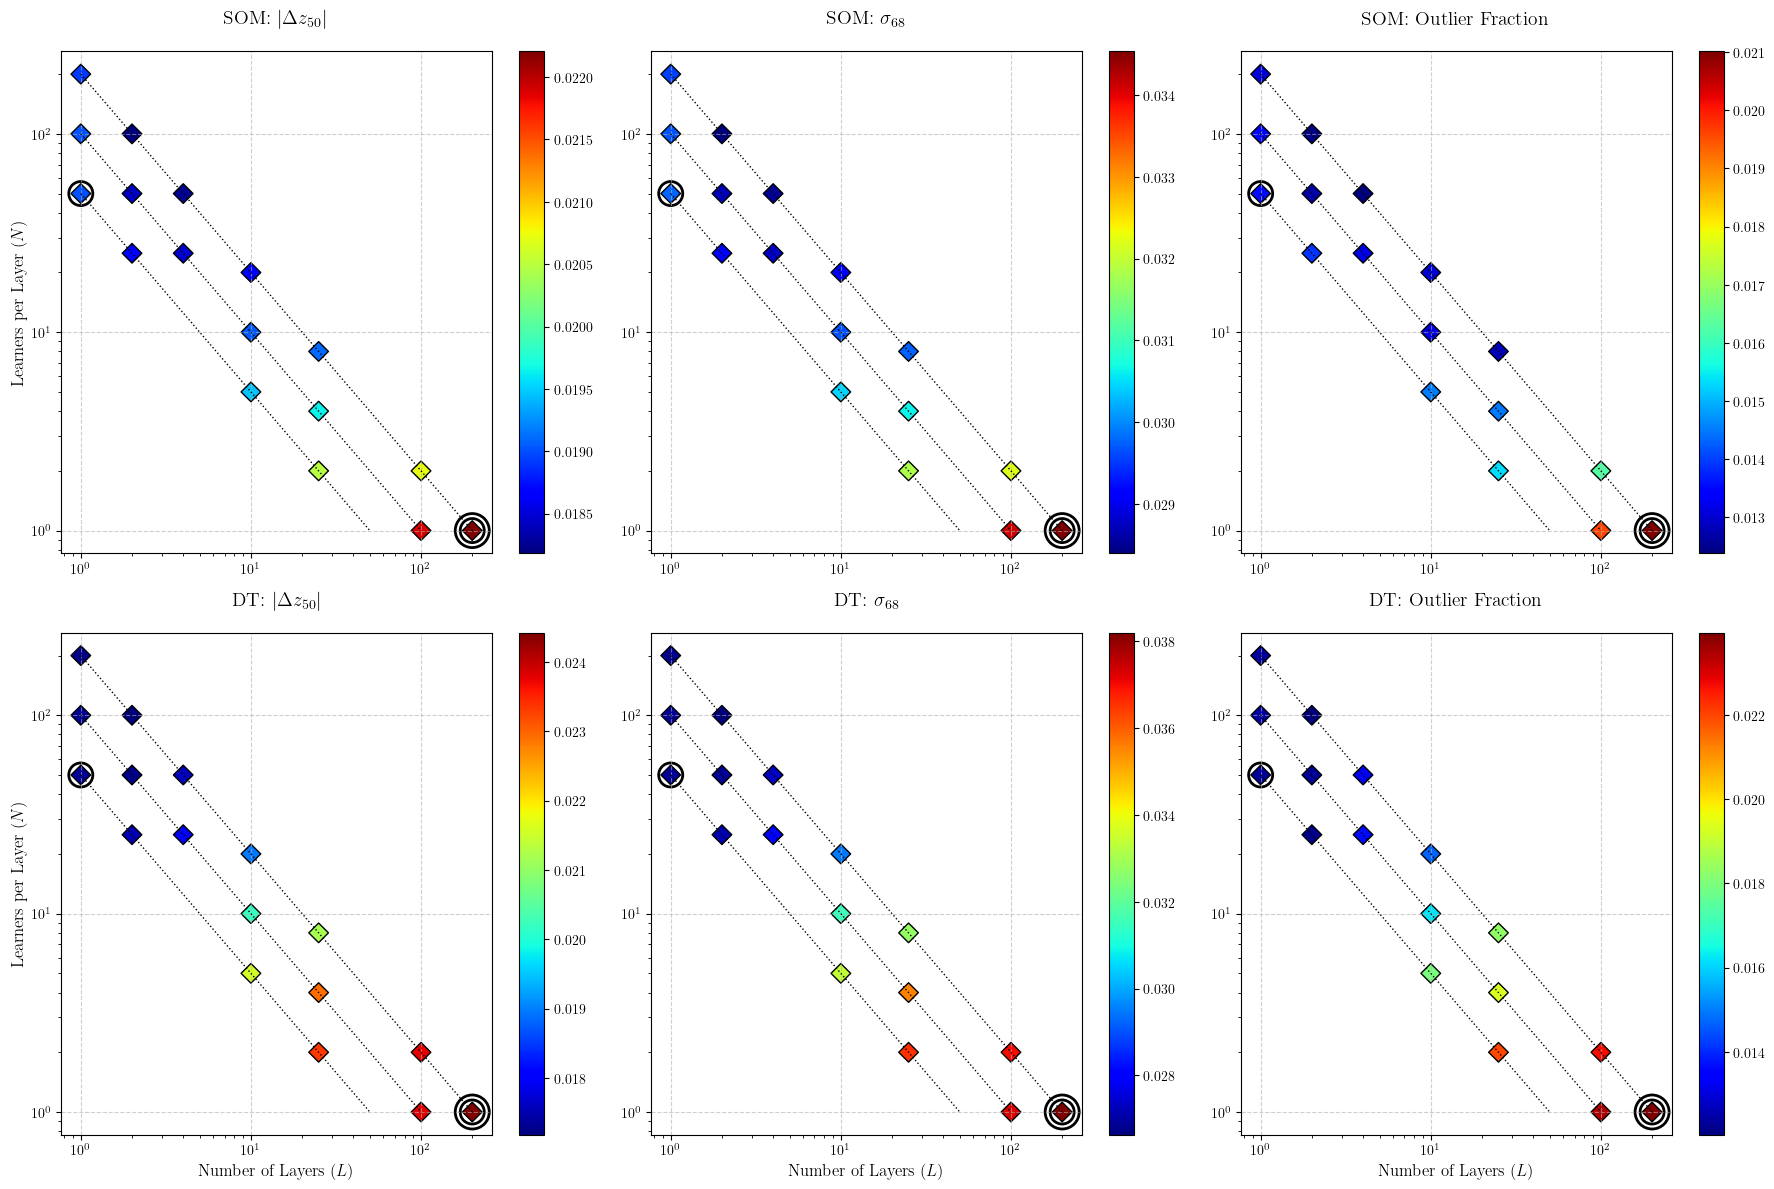

In [ ]:
metrics = [
    ("median_delta_z", r"$| \Delta z_{50} |$"),
    ("sigma_68", r"$\sigma_{68}$"),
    ("outlier_fraction", "Outlier Fraction")
]

titles = [
    r"SOM: $| \Delta z_{50} |$", r"SOM: $\sigma_{68}$", "SOM: Outlier Fraction",
    r"DT: $| \Delta z_{50} |$", r"DT: $\sigma_{68}$", "DT: Outlier Fraction"
]

def plot_scatter(ax, df, metric, title, cmap="jet"):
    ax.set_xscale('log')
    ax.set_yscale('log')

    scatter = ax.scatter(df["L"], df["N"], c=df[metric], cmap=cmap, 
                         marker='D', edgecolor='black', s=100)

    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label("")  
    ax.set_title(title, fontsize=14, pad=20)

    P_values = np.unique(df["L"] * df["N"])
    for P in P_values:
        ax.plot([1, P], [P, 1], linestyle=':', color='black', linewidth=1)

    comparison_L = 1
    comparison_N = df[df["L"] == comparison_L]["N"].min()
    ax.scatter(comparison_L, comparison_N, s=300, edgecolors='black', facecolors='none', linewidths=2)
    
    best_system = df.loc[df[metric].idxmax()]  # Best system has the smallest metric value
    best_L, best_N = best_system["L"], best_system["N"]
    for size in [300, 600]:
        ax.scatter(best_L, best_N, s=size, edgecolors='black', facecolors='none', linewidths=2)
    
    ax.grid(True, linestyle='--', alpha=0.6)


fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
axes = axes.flatten()

for i, (metric, label) in enumerate(metrics):
    plot_scatter(axes[i], df_SOM, metric, titles[i])  # SOM plots
    plot_scatter(axes[i + 3], df_DT, metric, titles[i + 3])  # DT plots

for ax in axes[3:6]:
    ax.set_xlabel(r"Number of Layers ($L$)", fontsize=12)

for ax in [axes[0], axes[3]]:
    ax.set_ylabel(r"Learners per Layer ($N$)", fontsize=12)


plt.tight_layout()
plt.savefig("figure2.png", bbox_inches="tight", dpi=300)
plt.show()


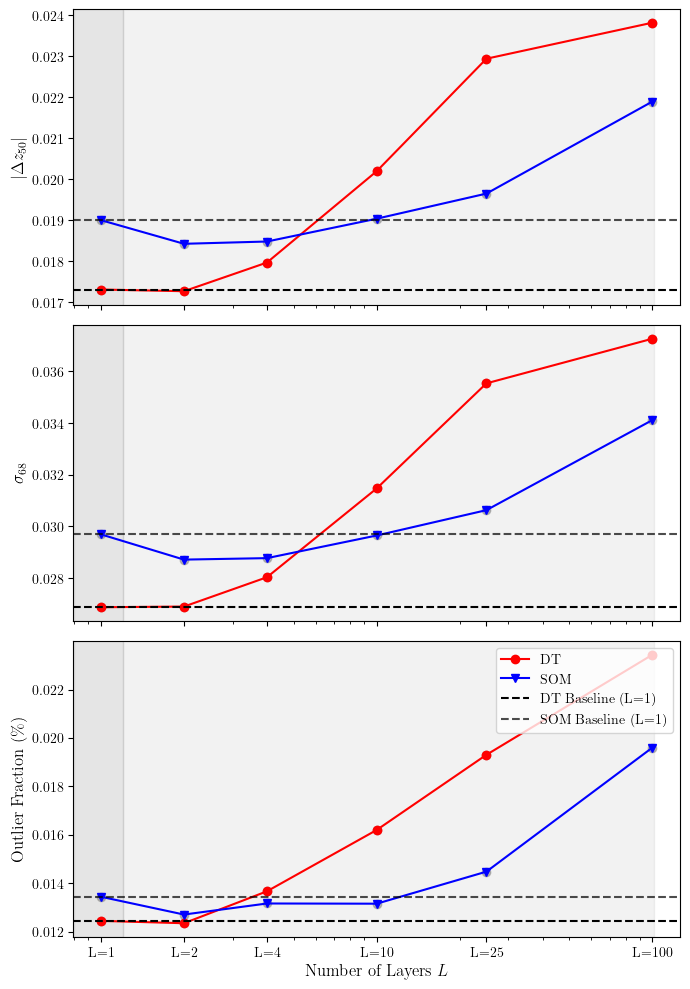

In [ ]:
df_DT_100 = df_DT[df_DT["P"] == 100]
df_SOM_100 = df_SOM[df_SOM["P"] == 100]


metrics = ["median_delta_z", "sigma_68", "outlier_fraction"]
metric_labels = [r"$|\Delta z_{50}|$", r"$\sigma_{68}$", r"Outlier Fraction (\%)"]
colors = {"DT": "red", "SOM": "blue"}
markers = {"DT": "o", "SOM": "v"}  

fig, axes = plt.subplots(3, 1, figsize=(7, 10), sharex=True)

for i, metric in enumerate(metrics):
    ax = axes[i]

    ax.plot(df_DT_100["L"], df_DT_100[metric], marker=markers["DT"], linestyle="-", color=colors["DT"], label="DT")
    ax.scatter(df_DT_100["L"], df_DT_100[metric], color="grey", alpha=0.5)  # Spread points

    ax.plot(df_SOM_100["L"], df_SOM_100[metric], marker=markers["SOM"], linestyle="-", color=colors["SOM"], label="SOM")
    ax.scatter(df_SOM_100["L"], df_SOM_100[metric], color="grey", alpha=0.5)  # Spread points

    ax.axvspan(0.8, 1.2, color="gray", alpha=0.2)
    ax.axvspan(1.2, max(df_DT_100["L"]) + 1, color="gray", alpha=0.1)

    dt_baseline = df_DT_100[df_DT_100["L"] == 1][metric].values[0]
    ax.axhline(y=dt_baseline, color="black", linestyle="dashed", label="DT Baseline (L=1)")

    som_baseline = df_SOM_100[df_SOM_100["L"] == 1][metric].values[0]
    ax.axhline(y=som_baseline, color="black", linestyle="dashed", alpha=0.7, label="SOM Baseline (L=1)")

    ax.set_xscale("log")  
    ax.set_xticks(df_DT_100["L"].values)
    ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: f"L={int(x)}"))

    ax.set_ylabel(metric_labels[i], fontsize=12)


axes[-1].legend(loc="upper right")
axes[-1].set_xlabel("Number of Layers $L$", fontsize=12)
plt.tight_layout()
plt.savefig("figure3.png", bbox_inches="tight")
plt.show()

In [ ]:
P_fixed = 100
L_values = [1, 2, 10, 50, 100]  
N_values = [P_fixed // L for L in L_values]  

df_som_768 = pd.DataFrame(columns=["L", "N", "P", "median_delta_z", "sigma_68", "outlier_fraction"])
df_som_3072 = pd.DataFrame(columns=["L", "N", "P", "median_delta_z", "sigma_68", "outlier_fraction"])

for L, N in zip(L_values, N_values):
    # Train SOM with 768 neurons
    som_model_768 = StackingManager(L=L, N=N, model_types=["som"], n_neurons=768)
    metrics_768 = train_and_evaluate(som_model_768, X_train, y_train, X_test, y_test)
    df_som_768.loc[len(df_som_768)] = [L, N, L*N, metrics_768["median_delta_z"], metrics_768["sigma_68"], metrics_768["outlier_fraction"]]

    # Train SOM with 3072 neurons
    som_model_3072 = StackingManager(L=L, N=N, model_types=["som"], n_neurons=3072)
    metrics_3072 = train_and_evaluate(som_model_3072, X_train, y_train, X_test, y_test)
    df_som_3072.loc[len(df_som_3072)] = [L, N, L*N, metrics_3072["median_delta_z"], metrics_3072["sigma_68"], metrics_3072["outlier_fraction"]]

df_som_768 = df_som_768.astype({"L": int, "N": int, "P":int, "median_delta_z": float, "sigma_68": float, "outlier_fraction": float})
df_som_3072 = df_som_3072.astype({"L": int, "N": int, "P":int, "median_delta_z": float, "sigma_68": float, "outlier_fraction": float})

df_som_768.to_csv('df_som_768.csv')
df_som_3072.to_csv('df_som_3072.csv')


🔹 Training Stacking Model with L = 1, N = 100, P = 100, Model = ['som']...
 Stacking Training Completed. 

🔹 Training Stacking Model with L = 1, N = 100, P = 100, Model = ['som']...
 Stacking Training Completed. 

🔹 Training Stacking Model with L = 2, N = 50, P = 100, Model = ['som']...
 Stacking Training Completed. 

🔹 Training Stacking Model with L = 2, N = 50, P = 100, Model = ['som']...
 Stacking Training Completed. 

🔹 Training Stacking Model with L = 10, N = 10, P = 100, Model = ['som']...
 Stacking Training Completed. 

🔹 Training Stacking Model with L = 10, N = 10, P = 100, Model = ['som']...
 Stacking Training Completed. 

🔹 Training Stacking Model with L = 50, N = 2, P = 100, Model = ['som']...
 Stacking Training Completed. 

🔹 Training Stacking Model with L = 50, N = 2, P = 100, Model = ['som']...
 Stacking Training Completed. 

🔹 Training Stacking Model with L = 100, N = 1, P = 100, Model = ['som']...
 Stacking Training Completed. 

🔹 Training Stacking Model with L = 100, N

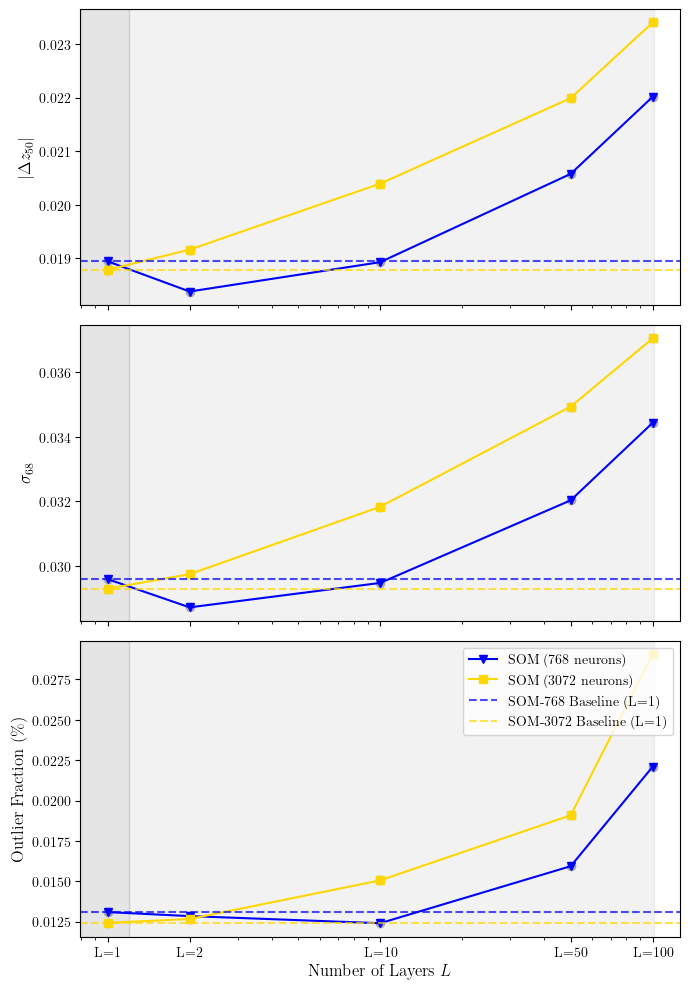

In [ ]:
# Extract baseline performance for L=1 (without stacking)
L1_som_768 = df_som_768[df_som_768["L"] == 1].mean()
L1_som_3072 = df_som_3072[df_som_3072["L"] == 1].mean()

metrics = ["median_delta_z", "sigma_68", "outlier_fraction"]
metric_labels = [r"$|\Delta z_{50}|$", r"$\sigma_{68}$", r"Outlier Fraction (\%)"]
colors = {"SOM_768": "blue", "SOM_3072": "gold"}
markers = {"SOM_768": "v", "SOM_3072": "s"} 


fig, axes = plt.subplots(3, 1, figsize=(7, 10), sharex=True)

for i, metric in enumerate(metrics):
    ax = axes[i]

    ax.plot(df_som_768["L"], df_som_768[metric], marker=markers["SOM_768"], linestyle="-", color=colors["SOM_768"], label="SOM (768 neurons)")
    ax.scatter(df_som_768["L"], df_som_768[metric], color="grey", alpha=0.5)  

    ax.plot(df_som_3072["L"], df_som_3072[metric], marker=markers["SOM_3072"], linestyle="-", color=colors["SOM_3072"], label="SOM (3072 neurons)")
    ax.scatter(df_som_3072["L"], df_som_3072[metric], color="grey", alpha=0.5)  

    ax.axvspan(0.8, 1.2, color="gray", alpha=0.2)

    ax.axvspan(1.2, max(df_som_768["L"]) + 1, color="gray", alpha=0.1)

    ax.axhline(y=L1_som_768[metric], linestyle="dashed", color="blue", alpha=0.7, label="SOM-768 Baseline (L=1)")
    ax.axhline(y=L1_som_3072[metric], linestyle="dashed", color="gold", alpha=0.7, label="SOM-3072 Baseline (L=1)")

    ax.set_xscale("log") 
    ax.set_xticks(df_som_768["L"].values)
    ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: f"L={int(x)}"))
    ax.set_ylabel(metric_labels[i], fontsize=12)


axes[-1].legend(loc="upper right")
axes[-1].set_xlabel("Number of Layers $L$", fontsize=12)
plt.tight_layout()
plt.savefig("figure4.png", bbox_inches="tight")
plt.show()


In [ ]:
min_samples_leaf_values = [100, 80, 60, 40, 20, 10, 1]

df_dt = pd.DataFrame(columns=["L", "N", "P", "min_samples_leaf", "median_delta_z", "sigma_68", "outlier_fraction"])

for min_samples_leaf in min_samples_leaf_values:
    print(f"🔹 Training DT models for min_samples_leaf = {min_samples_leaf}...")

    # No stacking
    L, N = 1, 400
    model_no_stacking = StackingManager(L=L, N=N, model_types=['dt'], min_samples_leaf=min_samples_leaf)
    model_no_stacking.train(X_train, y_train)
    metrics_no_stacking = model_no_stacking.evaluate(X_test, y_test)
    df_dt.loc[len(df_dt)] = [L, N, L*N, min_samples_leaf, 
                                       metrics_no_stacking["metrics"]["median_delta_z"],
                                       metrics_no_stacking["metrics"]["sigma_68"],
                                       metrics_no_stacking["metrics"]["outlier_fraction"]]

    # Stacking
    L, N = 2, 200
    model_stacking = StackingManager(L=L, N=N, model_types=['dt'], min_samples_leaf=min_samples_leaf)
    model_stacking.train(X_train, y_train)
    metrics_stacking = model_stacking.evaluate(X_test, y_test)
    df_dt.loc[len(df_dt)] = [L, N, L*N, min_samples_leaf, 
                                       metrics_stacking["metrics"]["median_delta_z"],
                                       metrics_stacking["metrics"]["sigma_68"],
                                       metrics_stacking["metrics"]["outlier_fraction"]]


df_dt = df_dt.astype({"L": int, "N": int, "P": int, "min_samples_leaf": int,"median_delta_z": float, "sigma_68": float, "outlier_fraction": float})

df_dt.to_csv('df_dt.csv')

🔹 Training DT models for min_samples_leaf = 100...
🔹 Training Stacking Model with L = 1, N = 400, P = 400, Model = ['dt']...
 Stacking Training Completed. 

🔹 Training Stacking Model with L = 2, N = 200, P = 400, Model = ['dt']...
 Stacking Training Completed. 

🔹 Training DT models for min_samples_leaf = 80...
🔹 Training Stacking Model with L = 1, N = 400, P = 400, Model = ['dt']...
 Stacking Training Completed. 

🔹 Training Stacking Model with L = 2, N = 200, P = 400, Model = ['dt']...
 Stacking Training Completed. 

🔹 Training DT models for min_samples_leaf = 60...
🔹 Training Stacking Model with L = 1, N = 400, P = 400, Model = ['dt']...
 Stacking Training Completed. 

🔹 Training Stacking Model with L = 2, N = 200, P = 400, Model = ['dt']...
 Stacking Training Completed. 

🔹 Training DT models for min_samples_leaf = 40...
🔹 Training Stacking Model with L = 1, N = 400, P = 400, Model = ['dt']...
 Stacking Training Completed. 

🔹 Training Stacking Model with L = 2, N = 200, P = 400, M

In [ ]:
# Extract baseline values for L=1 (no stacking)
baseline_median = df_dt[df_dt["L"] == 1]["median_delta_z"].values[0]
baseline_sigma = df_dt[df_dt["L"] == 1]["sigma_68"].values[0]
baseline_outlier = df_dt[df_dt["L"] == 1]["outlier_fraction"].values[0]

df_dt["rel_median"] = ((baseline_median - df_dt["median_delta_z"]) / baseline_median) * 100
df_dt["rel_sigma"] = ((baseline_sigma - df_dt["sigma_68"]) / baseline_sigma) * 100
df_dt["rel_outlier"] = ((baseline_outlier - df_dt["outlier_fraction"]) / baseline_outlier) * 100


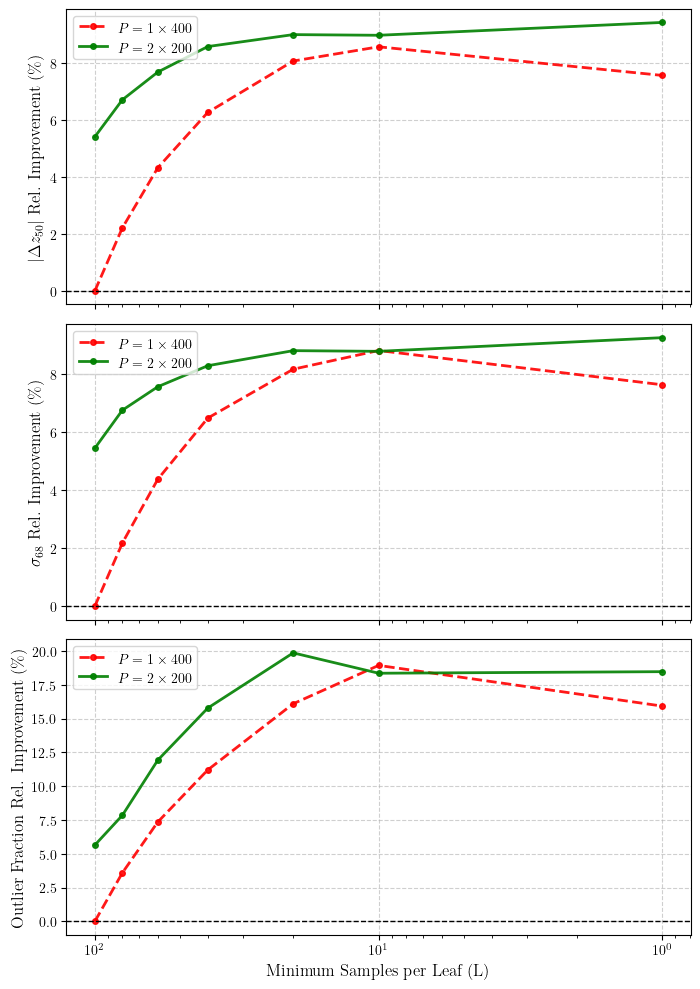

In [ ]:
metrics = [
    ("rel_median", r"$|\Delta z_{50}|$ Rel. Improvement (\%)"),
    ("rel_sigma", r"$\sigma_{68}$ Rel. Improvement (\%)"),
    ("rel_outlier", r"Outlier Fraction Rel. Improvement (\%)"),
]

fig, axes = plt.subplots(3, 1, figsize=(7, 10), sharex=True)


for i, (metric, ylabel) in enumerate(metrics):
    for (L, color, linestyle, label) in [(1, "red", "dashed", r"$P=1\times400$"),
                                         (2, "green", "solid", r"$P=2\times200$")]:
        subset = df_dt[df_dt["L"] == L]
        axes[i].plot(subset["min_samples_leaf"], subset[metric], linestyle=linestyle, linewidth=2,
                     color=color, marker="o", markersize=4, label=label, alpha=0.9)

    axes[i].axhline(y=0, color='black', linestyle='--', linewidth=1)
    axes[i].set_ylabel(ylabel, fontsize=12)
    axes[i].grid(True, linestyle="--", alpha=0.6)
    axes[i].legend(fontsize=10, loc="upper left")


axes[-1].set_xlabel("Minimum Samples per Leaf (L)", fontsize=12)
axes[-1].invert_xaxis()  
axes[-1].set_xscale("log")  
plt.tight_layout()
plt.savefig("figure5.png", bbox_inches="tight")
plt.show()


In [ ]:
M_values = [1, 10, 20, 30, 40, 50, 100]

df_adaboost = pd.DataFrame(columns=["L", "N", "P", "M", "median_delta_z", "sigma_68", "outlier_fraction"])

for M in M_values:
    print(f"🔹 Training AdaBoost models for M = {M} trees...")

    # No stacking
    model_no_stacking = StackingManager(L=1, N=100, model_types=['adaboost'], n_estimators=M)
    model_no_stacking.train(X_train, y_train)
    metrics_no_stacking = model_no_stacking.evaluate(X_test, y_test)
    df_adaboost.loc[len(df_adaboost)] = [1, 100, 100, M, 
                                         metrics_no_stacking["metrics"]["median_delta_z"],
                                         metrics_no_stacking["metrics"]["sigma_68"],
                                         metrics_no_stacking["metrics"]["outlier_fraction"]]

    # Stacking
    model_stacking = StackingManager(L=2, N=50, model_types=['adaboost'], n_estimators=M)
    model_stacking.train(X_train, y_train)
    metrics_stacking = model_stacking.evaluate(X_test, y_test)
    df_adaboost.loc[len(df_adaboost)] = [2, 50, 100, M, 
                                         metrics_stacking["metrics"]["median_delta_z"],
                                         metrics_stacking["metrics"]["sigma_68"],
                                         metrics_stacking["metrics"]["outlier_fraction"]]


df_adaboost = df_adaboost.astype({"L": int, "N": int, "P": int, "M": int, "median_delta_z": float, "sigma_68": float, "outlier_fraction": float})

df_adaboost.to_csv('df_adaboost.csv')

🔹 Training AdaBoost models for M = 1 trees...
🔹 Training Stacking Model with L = 1, N = 100, P = 100, Model = ['adaboost']...
 Stacking Training Completed. 

🔹 Training Stacking Model with L = 2, N = 50, P = 100, Model = ['adaboost']...
 Stacking Training Completed. 

🔹 Training AdaBoost models for M = 10 trees...
🔹 Training Stacking Model with L = 1, N = 100, P = 100, Model = ['adaboost']...
 Stacking Training Completed. 

🔹 Training Stacking Model with L = 2, N = 50, P = 100, Model = ['adaboost']...
 Stacking Training Completed. 

🔹 Training AdaBoost models for M = 20 trees...
🔹 Training Stacking Model with L = 1, N = 100, P = 100, Model = ['adaboost']...
 Stacking Training Completed. 

🔹 Training Stacking Model with L = 2, N = 50, P = 100, Model = ['adaboost']...
 Stacking Training Completed. 

🔹 Training AdaBoost models for M = 30 trees...
🔹 Training Stacking Model with L = 1, N = 100, P = 100, Model = ['adaboost']...
 Stacking Training Completed. 

🔹 Training Stacking Model with L

In [55]:
# Extract baseline values for largest M (M=1)
baseline_median = df_adaboost[df_adaboost["M"] == 1]["median_delta_z"].values[0]
baseline_sigma = df_adaboost[df_adaboost["M"] == 1]["sigma_68"].values[0]
baseline_outlier = df_adaboost[df_adaboost["M"] == 1]["outlier_fraction"].values[0]

# Compute relative improvement
df_adaboost["rel_median"] = ((baseline_median - df_adaboost["median_delta_z"]) / baseline_median) * 100
df_adaboost["rel_sigma"] = ((baseline_sigma - df_adaboost["sigma_68"]) / baseline_sigma) * 100
df_adaboost["rel_outlier"] = ((baseline_outlier - df_adaboost["outlier_fraction"]) / baseline_outlier) * 100

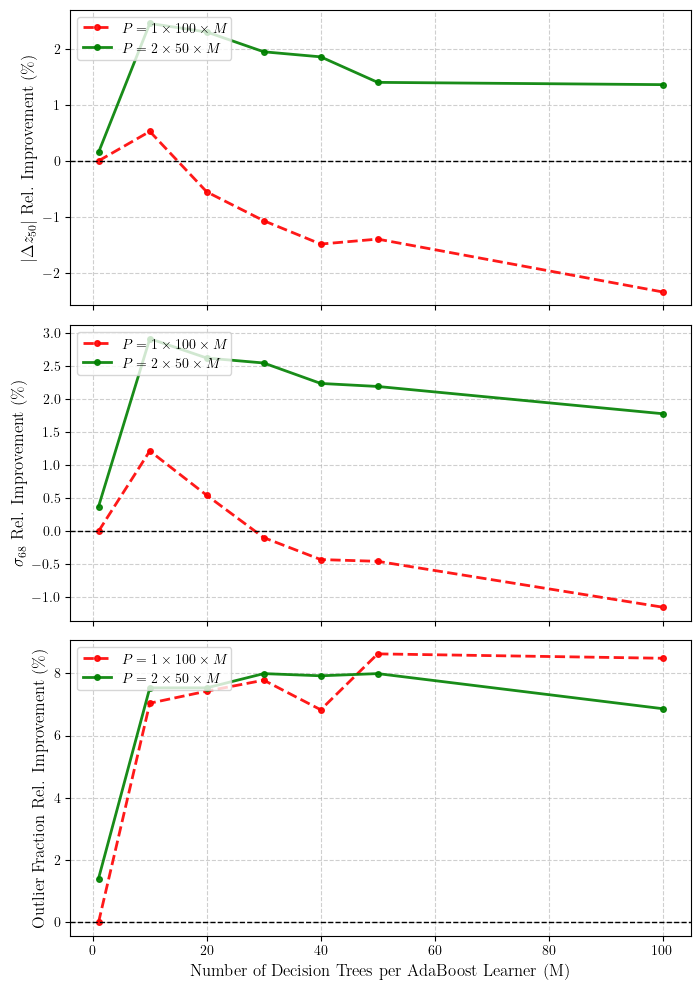

In [ ]:
metrics = [
    ("rel_median", r"$|\Delta z_{50}|$ Rel. Improvement (\%)"),
    ("rel_sigma", r"$\sigma_{68}$ Rel. Improvement (\%)"),
    ("rel_outlier", r"Outlier Fraction Rel. Improvement (\%)"),
]


fig, axes = plt.subplots(3, 1, figsize=(7, 10), sharex=True)


for i, (metric, ylabel) in enumerate(metrics):
    for (L, color, linestyle, label) in [(1, "red", "dashed", r"$P=1\times100\times M$"),
                                         (2, "green", "solid", r"$P=2\times50\times M$")]:
        subset = df_adaboost[df_adaboost["L"] == L]
        axes[i].plot(subset["M"], subset[metric], linestyle=linestyle, linewidth=2,
                     color=color, marker="o", markersize=4, label=label, alpha=0.9)

    axes[i].axhline(y=0, color='black', linestyle='--', linewidth=1)
    axes[i].set_ylabel(ylabel, fontsize=12)
    axes[i].grid(True, linestyle="--", alpha=0.6)
    axes[i].legend(fontsize=10, loc="upper left")


axes[-1].set_xlabel("Number of Decision Trees per AdaBoost Learner (M)", fontsize=12)
plt.tight_layout()
plt.savefig("figure6.png", bbox_inches="tight")
plt.show()


In [ ]:
M_values = [1, 10, 20, 30, 40, 50, 100]

df_xgboost = pd.DataFrame(columns=["L", "N", "P", "M", "median_delta_z", "sigma_68", "outlier_fraction"])

for M in M_values:
    print(f"🔹 Training XGBoost models for M = {M} trees...")

    # No stacking
    model_no_stacking = StackingManager(L=1, N=100, model_types=['xgboost'], n_estimators=M)
    model_no_stacking.train(X_train, y_train)
    metrics_no_stacking = model_no_stacking.evaluate(X_test, y_test)
    df_xgboost.loc[len(df_xgboost)] = [1, 100, 100, M, 
                                         metrics_no_stacking["metrics"]["median_delta_z"],
                                         metrics_no_stacking["metrics"]["sigma_68"],
                                         metrics_no_stacking["metrics"]["outlier_fraction"]]

    # Stacking
    model_stacking = StackingManager(L=2, N=50, model_types=['xgboost'], n_estimators=M)
    model_stacking.train(X_train, y_train)
    metrics_stacking = model_stacking.evaluate(X_test, y_test)
    df_xgboost.loc[len(df_xgboost)] = [2, 50, 100, M, 
                                         metrics_stacking["metrics"]["median_delta_z"],
                                         metrics_stacking["metrics"]["sigma_68"],
                                         metrics_stacking["metrics"]["outlier_fraction"]]


df_xgboost = df_xgboost.astype({"L": int, "N": int, "P": int, "M": int, "median_delta_z": float, "sigma_68": float, "outlier_fraction": float})

df_xgboost.to_csv('df_xgboost.csv')

🔹 Training XGBoost models for M = 1 trees...
🔹 Training Stacking Model with L = 1, N = 100, P = 100, Model = ['xgboost']...
 Stacking Training Completed. 

🔹 Training Stacking Model with L = 2, N = 50, P = 100, Model = ['xgboost']...
 Stacking Training Completed. 

🔹 Training XGBoost models for M = 10 trees...
🔹 Training Stacking Model with L = 1, N = 100, P = 100, Model = ['xgboost']...
 Stacking Training Completed. 

🔹 Training Stacking Model with L = 2, N = 50, P = 100, Model = ['xgboost']...
 Stacking Training Completed. 

🔹 Training XGBoost models for M = 20 trees...
🔹 Training Stacking Model with L = 1, N = 100, P = 100, Model = ['xgboost']...
 Stacking Training Completed. 

🔹 Training Stacking Model with L = 2, N = 50, P = 100, Model = ['xgboost']...
 Stacking Training Completed. 

🔹 Training XGBoost models for M = 30 trees...
🔹 Training Stacking Model with L = 1, N = 100, P = 100, Model = ['xgboost']...
 Stacking Training Completed. 

🔹 Training Stacking Model with L = 2, N = 5

In [46]:
# Extract baseline values for largest M (M=1)
baseline_median = df_xgboost[df_xgboost["M"] == 1]["median_delta_z"].values[0]
baseline_sigma = df_xgboost[df_xgboost["M"] == 1]["sigma_68"].values[0]
baseline_outlier = df_xgboost[df_xgboost["M"] == 1]["outlier_fraction"].values[0]

# Compute relative improvement
df_xgboost["rel_median"] = ((baseline_median - df_xgboost["median_delta_z"]) / baseline_median) * 100
df_xgboost["rel_sigma"] = ((baseline_sigma - df_xgboost["sigma_68"]) / baseline_sigma) * 100
df_xgboost["rel_outlier"] = ((baseline_outlier - df_xgboost["outlier_fraction"]) / baseline_outlier) * 100

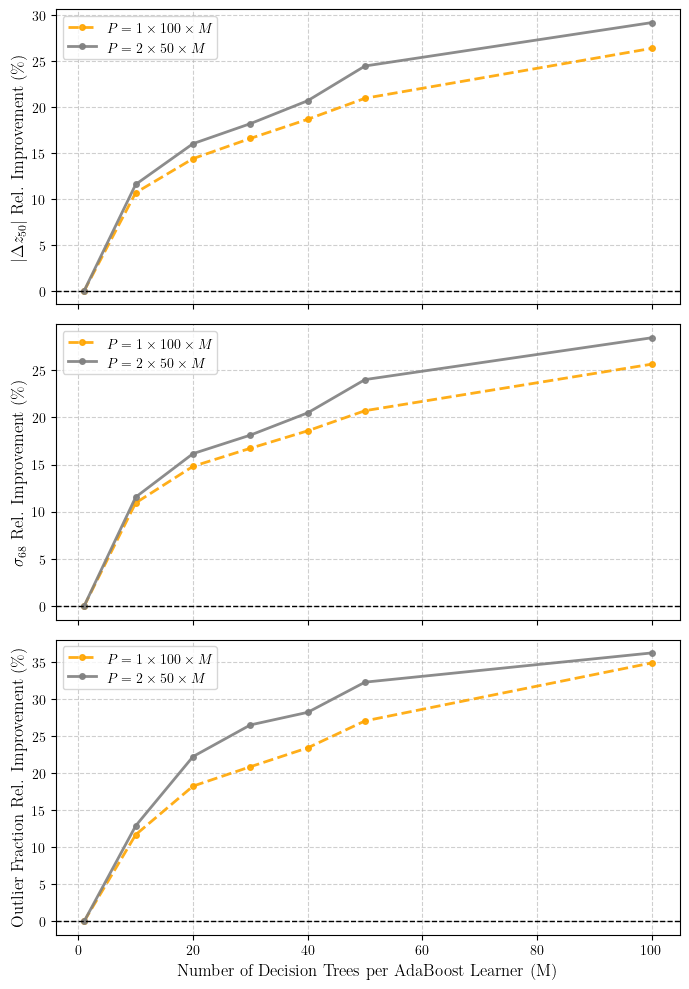

In [ ]:
metrics = [
    ("rel_median", r"$|\Delta z_{50}|$ Rel. Improvement (\%)"),
    ("rel_sigma", r"$\sigma_{68}$ Rel. Improvement (\%)"),
    ("rel_outlier", r"Outlier Fraction Rel. Improvement (\%)"),
]


fig, axes = plt.subplots(3, 1, figsize=(7, 10), sharex=True)


for i, (metric, ylabel) in enumerate(metrics):
    for (L, color, linestyle, label) in [(1, "orange", "dashed", r"$P=1\times100\times M$"),
                                         (2, "grey", "solid", r"$P=2\times50\times M$")]:
        subset = df_xgboost[df_xgboost["L"] == L]
        axes[i].plot(subset["M"], subset[metric], linestyle=linestyle, linewidth=2,
                     color=color, marker="o", markersize=4, label=label, alpha=0.9)

    axes[i].axhline(y=0, color='black', linestyle='--', linewidth=1)
    axes[i].set_ylabel(ylabel, fontsize=12)
    axes[i].grid(True, linestyle="--", alpha=0.6)
    axes[i].legend(fontsize=10, loc="upper left")


axes[-1].set_xlabel("Number of Decision Trees per AdaBoost Learner (M)", fontsize=12)
plt.tight_layout()
plt.savefig("xgboost.png", bbox_inches="tight")
plt.show()


### fig 7

In [48]:
results_som_no_stacking = df_som_3072[(df_som_3072["L"] == 1) & (df_som_3072["P"] == 100)].iloc[0]
results_som_stacking = df_som_3072[(df_som_3072["L"] == 100) & (df_som_3072["P"] == 100)].iloc[0]

results_dt_no_stacking = df_DT[(df_DT["L"] == 1) & (df_DT["P"] == 400) & (df_DT["min_samples_leaf"] == 20)].iloc[0]
results_dt_stacking = df_DT[(df_DT["L"] == 2) & (df_DT["P"] == 400) & (df_DT["min_samples_leaf"] == 20)].iloc[0]

results_adaboost_no_stacking = df_adaboost[(df_adaboost["L"] == 1) & (df_adaboost["P"] == 100) & (df_adaboost["M"] == 10)].iloc[0]
results_adaboost_stacking = df_adaboost[(df_adaboost["L"] == 2) & (df_adaboost["P"] == 100) & (df_adaboost["M"] == 10)].iloc[0]

results_xgboost_no_stacking = df_xgboost[(df_xgboost["L"] == 1) & (df_xgboost["P"] == 100) & (df_xgboost["M"] == 10)].iloc[0]
results_xgboost_stacking = df_xgboost[(df_xgboost["L"] == 2) & (df_xgboost["P"] == 100) & (df_xgboost["M"] == 10)].iloc[0]

# Store extracted values in lists
median_no_stacking = np.array([results_som_no_stacking["median_delta_z"], 
                               results_dt_no_stacking["median_delta_z"], 
                               results_adaboost_no_stacking["median_delta_z"],
                               results_xgboost_no_stacking["median_delta_z"]])

median_stacking = np.array([results_som_stacking["median_delta_z"], 
                            results_dt_stacking["median_delta_z"], 
                            results_adaboost_stacking["median_delta_z"],
                            results_xgboost_stacking["median_delta_z"]])

sigma_no_stacking = np.array([results_som_no_stacking["sigma_68"], 
                              results_dt_no_stacking["sigma_68"], 
                              results_adaboost_no_stacking["sigma_68"],
                              results_xgboost_no_stacking["sigma_68"]])

sigma_stacking = np.array([results_som_stacking["sigma_68"], 
                           results_dt_stacking["sigma_68"], 
                           results_adaboost_stacking["sigma_68"],
                           results_xgboost_stacking["sigma_68"]])

outlier_no_stacking = np.array([results_som_no_stacking["outlier_fraction"], 
                                results_dt_no_stacking["outlier_fraction"], 
                                results_adaboost_no_stacking["outlier_fraction"],
                                results_xgboost_no_stacking["outlier_fraction"]])

outlier_stacking = np.array([results_som_stacking["outlier_fraction"], 
                             results_dt_stacking["outlier_fraction"], 
                             results_adaboost_stacking["outlier_fraction"],
                             results_xgboost_stacking["outlier_fraction"]])


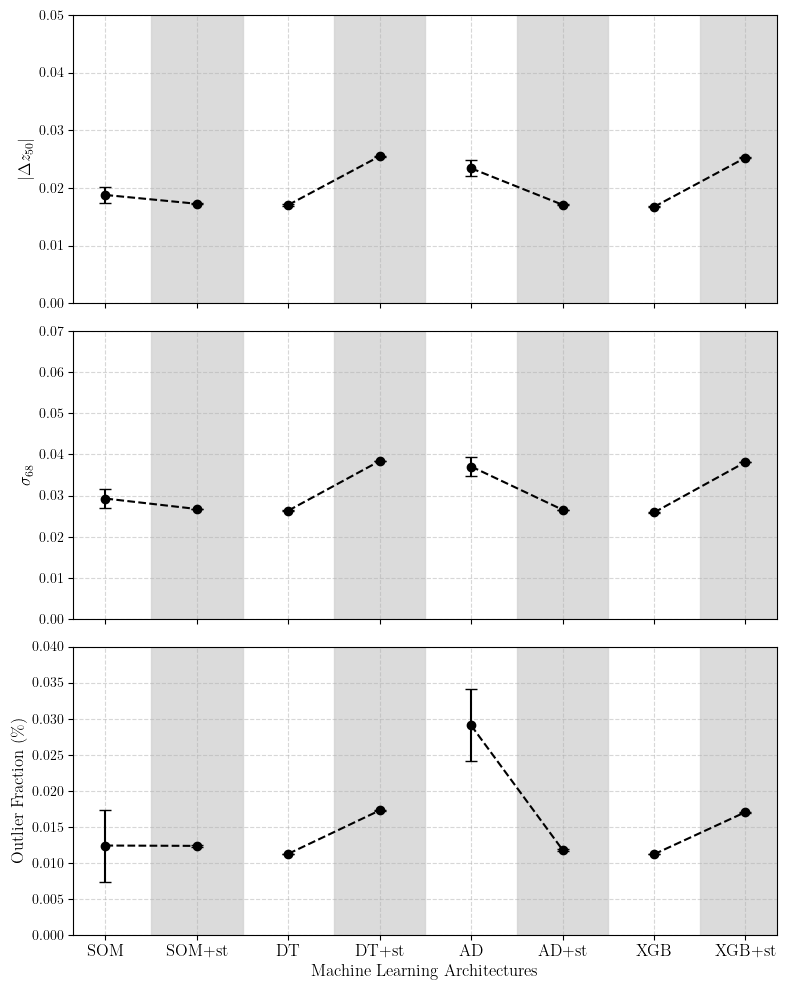

In [ ]:
# Compute absolute values
abs_median = np.abs(np.concatenate((median_no_stacking, median_stacking)))
abs_sigma = np.abs(np.concatenate((sigma_no_stacking, sigma_stacking)))
abs_outlier = np.abs(np.concatenate((outlier_no_stacking, outlier_stacking)))

# Compute errors (factor of 0.3)
error_median = 0.3 * np.abs(median_no_stacking - median_stacking)
error_sigma = 0.3 * np.abs(sigma_no_stacking - sigma_stacking)
error_outlier = 0.3 * np.abs(outlier_no_stacking - outlier_stacking)

error_median = np.concatenate((error_median, error_median))
error_sigma = np.concatenate((error_sigma, error_sigma))
error_outlier = np.concatenate((error_outlier, error_outlier))


models = ["SOM", "SOM+st", "DT", "DT+st", "AD", "AD+st", "XGB", "XGB+st"]
x = np.arange(len(models))

fig, axes = plt.subplots(3, 1, figsize=(8, 10), sharex=True)

metric_labels = [r"$|\Delta z_{50}|$", r"$\sigma_{68}$", r"Outlier Fraction (\%)"]
data_values = [abs_median, abs_sigma, abs_outlier]
error_values = [error_median, error_sigma, error_outlier]
y_limits = [(0, 0.05), (0, 0.07), (0, 0.04)] 

for i, (values, errors, ylabel, ylim) in enumerate(zip(data_values, error_values, metric_labels, y_limits)):
    axes[i].errorbar(x, values, yerr=errors, fmt="o", color="black", capsize=4)

    for j in range(0, len(x), 2):
        axes[i].plot([x[j], x[j + 1]], [values[j], values[j + 1]], linestyle="dashed", color="black")

    for j in range(1, len(x), 2):
        axes[i].axvspan(j - 0.5, j + 0.5, color="lightgray", alpha=0.8)

    axes[i].set_ylabel(ylabel, fontsize=12)
    axes[i].grid(True, linestyle="--", alpha=0.5)
    axes[i].set_ylim(ylim)  
    axes[i].set_xticks(x)
    axes[i].set_xticklabels(models, fontsize=12)

axes[-1].set_xlabel("Machine Learning Architectures", fontsize=12)

plt.tight_layout()
plt.savefig("figure7.png", bbox_inches="tight")
plt.show()


### Results

In [ ]:
table_3_data = {
    "Algorithm": [
        "SOM without stacking", "SOM with stacking",
        "Decision Trees without stacking", "Decision Trees with stacking",
        "AdaBoost without stacking", "AdaBoost with stacking",
        "XGBoost without stacking", "XGBoost with stacking"
    ],
    "|Δz₅₀|": median_no_stacking.tolist() + median_stacking.tolist(),
    "σ₆₈": sigma_no_stacking.tolist() + sigma_stacking.tolist(),
    "Outlier Fraction (%)": (outlier_no_stacking).tolist() + (outlier_stacking).tolist()
}

result = pd.DataFrame(table_3_data)
result.to_csv('result.csv', index=False)

In [60]:
result

,Algorithm,|Δz₅₀|,σ₆₈,Outlier Fraction (%)
0,SOM without stacking,0.018787,0.029292,0.012427
1,SOM with stacking,0.017261,0.026753,0.012380
2,Decision Trees without stacking,0.017058,0.026361,0.011282
3,Decision Trees with stacking,0.025501,0.038396,0.017299
4,AdaBoost without stacking,0.023399,0.037058,0.029068
5,AdaBoost with stacking,0.017087,0.026566,0.011825
6,XGBoost without stacking,0.016727,0.025907,0.011222
7,XGBoost with stacking,0.025243,0.038131,0.017064
